In [1]:
import pandas as pd

In [2]:
df_eth = pd.read_excel('ethereum.xlsx', sheet_name = 'Data', skiprows = 4)
df_eth = df_eth.iloc[:,1:]
df_eth.columns = ['date', 'price']
df_eth['date'] = pd.to_datetime(df_eth['date'], format='%b %d, %Y')
df_eth.head()
# df_spx = pd.read_csv('spx.csv', index = False)

,date,price
0,2022-06-07,1814.05
1,2022-06-08,1793.57
2,2022-06-09,1789.83
3,2022-06-10,1665.04
4,2022-06-11,1529.66


In [3]:
df_spx = pd.read_csv('spx.csv')
df_spx.columns = [x.lower() for x in df_spx.columns]

df_spx['date'] =  pd.to_datetime(df_spx['date'], format='%m/%d/%Y')
df_spx.rename(columns={'close/last':'close'}, inplace = True)
df_spx = df_spx.sort_values(by='date').reset_index().drop(columns='index')
df_spx.head()

,date,close,open,high,low
0,2020-03-03,3003.37,3096.46,3136.72,2976.63
1,2020-03-04,3130.12,3045.75,3130.97,3034.38
2,2020-03-05,3023.94,3075.70,3083.04,2999.83
3,2020-03-06,2972.37,2954.20,2985.93,2901.54
4,2020-03-09,2746.56,2863.89,2863.89,2734.43


## EDA

In [32]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df_eth, explorative=True)
profile

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


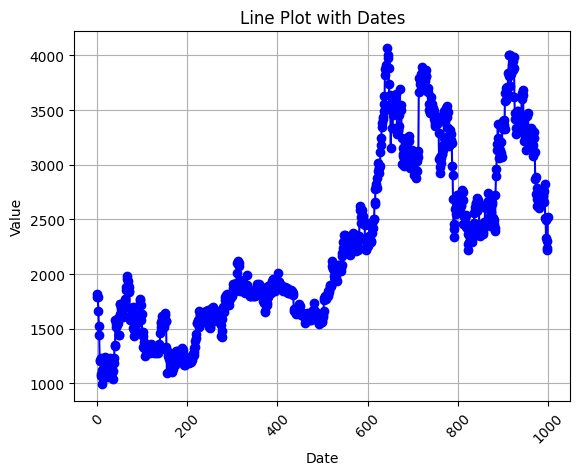

In [4]:
import  matplotlib.pyplot as plt
import numpy as np

# df_eth_prev = df_eth[(df_eth.date >= '2024-01-01') & (df_eth.date <= '2024-12-31')]
df_eth_prev = df_eth[(df_eth.date >= '2024-01-01')]

# plt.plot(df_eth_prev['date'], df_eth_prev['price'])

plt.plot(range(len(df_eth)), np.array(df_eth.price), marker="o", linestyle="-", color="b")

# Formatting
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Line Plot with Dates")
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.grid(True)


In [52]:
df_eth['pct_change'] = df_eth['price'].pct_change()
df_eth['pct_change'] = df_eth['pct_change'].fillna(0)

In [5]:
plt.plot(list(df_eth['date']), np.array(df_eth['pct_change']), marker="o", linestyle="-", color="b")

# Formatting
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Line Plot with Dates")
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.grid(True)

KeyError: 'pct_change'

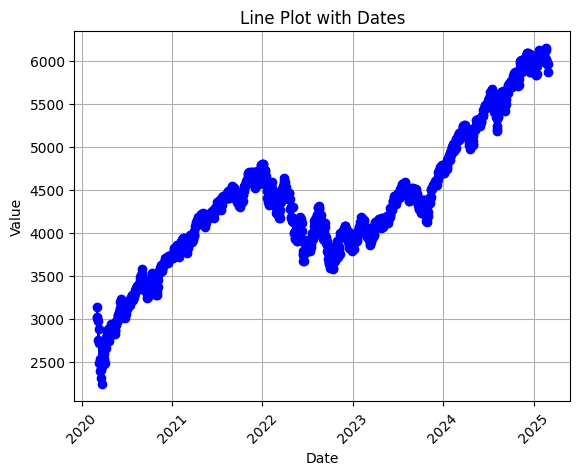

In [62]:
# df_eth_prev = df_eth[(df_eth.date >= '2024-01-01') & (df_eth.date <= '2024-12-31')]
# df_eth_prev = df_eth[(df_eth.date >= '2024-01-01')]

# plt.plot(df_eth_prev['date'], df_eth_prev['price'])

plt.plot(list(df_spx.date), np.array(df_spx.close), marker="o", linestyle="-", color="b")

# Formatting
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Line Plot with Dates")
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.grid(True)

In [6]:
def profit_spx(keep_day, trade_duration):
    # asset grow calculation
    # trade_duration = 90
    day = keep_day
    calculate_days_process = day - round(day/7)*2
    # print(calculate_days_process)

    # batch = round(len(df_spx)/calculate_days_process)
    # print(batch)
    roi_list = []

    for i in range(len(df_spx)-calculate_days_process):
        df_temp = df_spx.loc[i:i+calculate_days_process,:] 
        pct_change = (df_temp.tail(1)['close'].values - df_temp.head(1)['close'].values)*100.00/df_temp.head(1)['close'].values
        roi = round(((df_temp.tail(1)['close'].values)*pct_change/100 / (df_temp.tail(1)['close'].values))[0], 3)
        roi_list.append(roi)                                                 

    avg_roi = sum(roi_list) / len(roi_list)
    est_roi = trade_duration / day * avg_roi

    return(est_roi)

In [10]:
days = [1,7,30, 60, 90]
keep = [30, 60, 90, 150, 350, 700, 1050, 1400]

max_roi_spx = 0
best_params_spx = dict()

optime_roi_spx = dict()
optime_roi_spx['day'] = 99999
optime_roi_spx['duration'] = 99999
optime_roi_spx['effort'] = 99999
optime_roi_spx['roi'] = 99999

for val in keep:
    for day in days:

        effort_spx = val / day
        roi_spx = profit_spx(day, val)

        if roi_spx>max_roi_spx:
            max_roi_spx = profit_spx(day, val)
            best_params_spx['day'] = day
            best_params_spx['duration'] = val
            best_params_spx['roi'] = max_roi_spx
        
        if (roi_spx >= 1) and (val <= optime_roi_spx['duration']) and (effort_spx < optime_roi_spx['duration']):
            optime_roi_spx['day'] = day
            optime_roi_spx['duration'] = val
            optime_roi_spx['effort'] = effort_spx 
            optime_roi_spx['roi'] = roi_spx

In [11]:
best_params_spx

{'day': 1, 'duration': 1400, 'roi': 0.8879681274900405}

In [12]:
optime_roi_spx

{'day': 99999, 'duration': 99999, 'effort': 99999, 'roi': 99999}

In [166]:
def profit_eth(keep_day, trade_duration):
    # asset grow calculation
    day = keep_day
    calculate_days_process = day - round(day/7)*2
    # print(calculate_days_process)

    roi_list = []

    for i in range(len(df_eth)-calculate_days_process):
        df_temp = df_eth.loc[i:i+calculate_days_process,:] 
        pct_change = (df_temp.tail(1)['price'].values - df_temp.head(1)['price'].values)*100.00/df_temp.head(1)['price'].values
        roi = round(((df_temp.tail(1)['price'].values)*pct_change/100 / (df_temp.tail(1)['price'].values))[0], 3)
        roi_list.append(roi)                                                 

    avg_roi = sum(roi_list) / len(roi_list)
    est_roi = trade_duration / day * avg_roi

    return(est_roi)

In [195]:
days = [1,7,30, 60, 90]
keep = [30, 60, 90, 150, 350, 700, 1050, 1400]

max_roi = 0
best_params = dict()

# best_params['day'] = 99999
# best_params['duration'] = 99999
# best_params['roi'] = 99999

optime_roi = dict()
optime_roi['day'] = 99999
optime_roi['duration'] = 99999
optime_roi['effort'] = 99999
optime_roi['roi'] = 99999

for val in keep:
    for day in days:
        roi = profit_eth(day, val)
        effort = val / day
        
        if roi > max_roi:
            max_roi = profit_eth(day, val)
            best_params['day'] = day
            best_params['duration'] = val
            best_params['effort'] = effort
            best_params['roi'] = max_roi
        
        if (roi >= 1) and (val <= optime_roi['duration']) and (effort < optime_roi['duration']):
            optime_roi['day'] = day
            optime_roi['duration'] = val
            optime_roi['effort'] = effort
            optime_roi['roi'] = roi

In [191]:
best_params

{'day': 60,
 'duration': 1400,
 'effort': 23.333333333333332,
 'roi': 1.3419345859429384}

In [194]:
optime_roi

{'day': 90,
 'duration': 1400,
 'effort': 15.555555555555555,
 'roi': 1.2912108262108295}